📊 Extracted DataFrame with columns ['Reaction Time [min]', 'pH'] and ['RNA [g/L]']
X shape: (10, 2), y shape: (10, 1)
X head:
   Reaction Time [min]    pH
0                    0  6.57
1                    4  6.52
2                    8  6.49
3                   13  6.41
4                   18  6.37
y head:
   RNA [g/L]
0   0.000000
1   1.322399
2   2.844903
3   5.138938
4   7.869962
📊 Extracted DataFrame with columns ['Reaction Time [min]', 'pH'] and ['RNA [g/L]']
X shape: (9, 2), y shape: (9, 1)
X head:
   Reaction Time [min]    pH
0                    0  6.69
1                    4  6.63
2                    8  6.58
3                   18  6.47
4                   23  6.44
y head:
   RNA [g/L]
0   0.000000
1   2.051094
2   4.190807
3   8.688998
4  13.452314


<Axes: xlabel='Reaction Time [min]'>

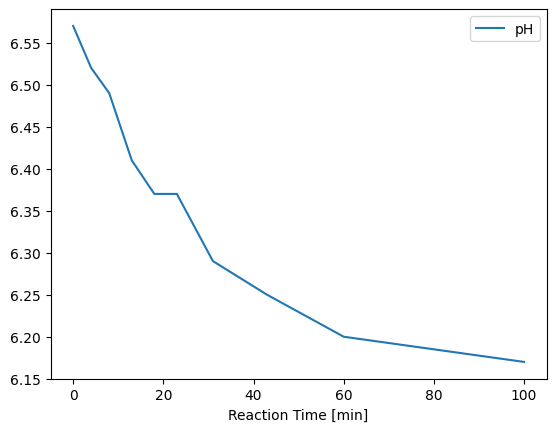

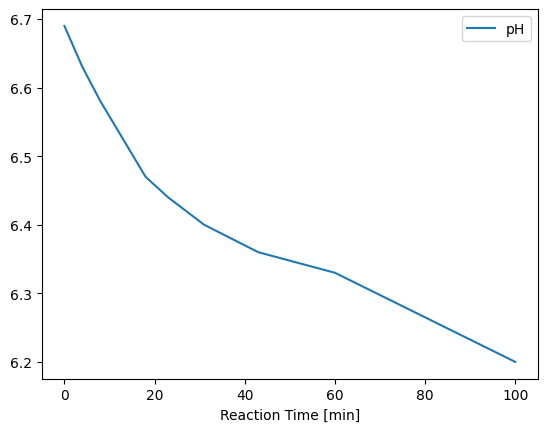

In [4]:
import r3.adapters as adapters
import r3.schema as schema
import os

home_directory = os.path.expanduser("~")
root_data_dir = os.path.join(
    home_directory, "protocol", "r3", "data", "experimental_data"
)


X_columns = [schema.IVTReactionSchema.TIME_min.value, schema.IVTReactionSchema.pH.value]

y_columns = [
    schema.IVTReactionSchema.RNA_g_L.value,
]

X_train, y_train = adapters.DataPipelineAdapter("ph_repeat", root=root_data_dir).get(
    X_columns=X_columns,
    y_columns=y_columns,
)


X_test, y_test = adapters.DataPipelineAdapter("charlie_ph", root=root_data_dir).get(
    X_columns=X_columns,
    y_columns=y_columns,
)

X_train.plot(x=schema.IVTReactionSchema.TIME_min.value)
X_test.plot(x=schema.IVTReactionSchema.TIME_min.value)

# Training an XGboost model using the training data set

The idea is that XGboost can learn the discrepancy in the predictions of the kinetic
model


Training MSE: 0.0030
Training R^2: 0.9999
Test MSE: 7.7242
Test R^2: 0.7323


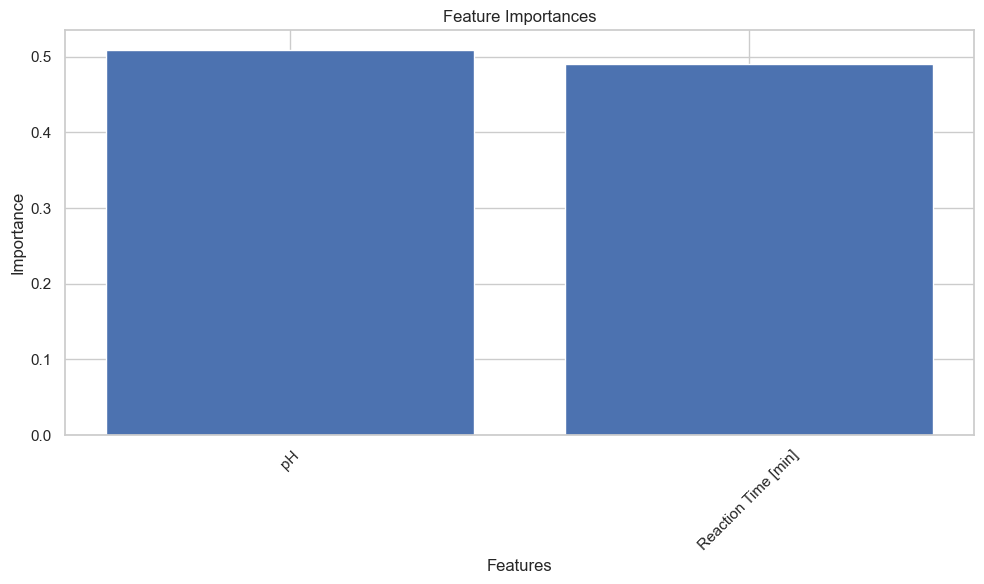

In [7]:
import xgboost as xgb

model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

model.fit(X_train.values, y_train.values.ravel())

# show performance on training set
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_train.values)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print(f"Training MSE: {mse:.4f}")
print(f"Training R^2: {r2:.4f}")


# show performance on test set
y_pred_test = model.predict(X_test.values)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"Test MSE: {mse_test:.4f}")
print(f"Test R^2: {r2_test:.4f}")


# show feature importance
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
importances = model.feature_importances_
feature_names = X_train.columns
indices = importances.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()

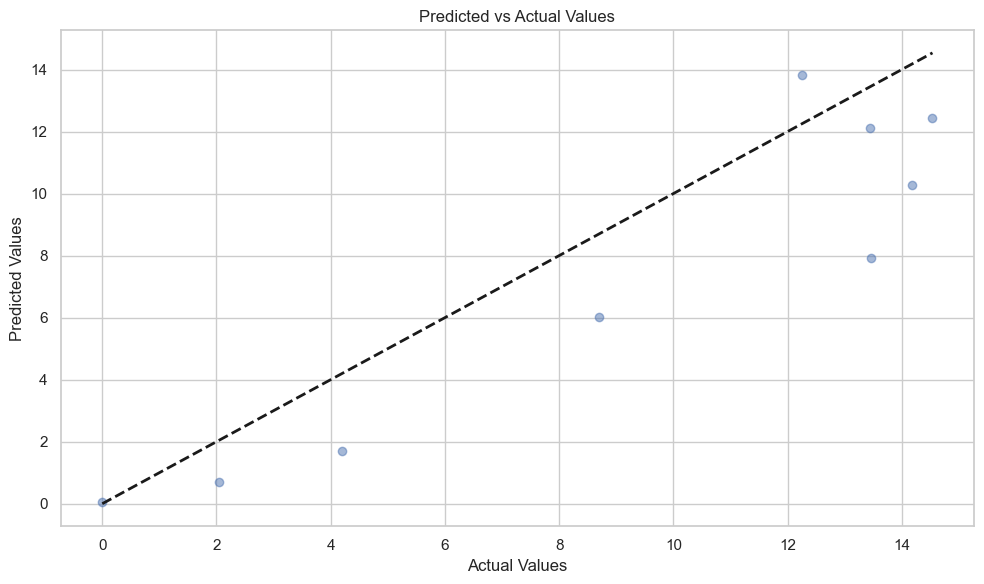

In [8]:
# show predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.tight_layout()